## Deep Learning Spring 2025: Final Project

#### Pooja Gayathri Kanala - pk2921<br> Srushti Shah - ss17021<br> Subhiksha Seshadri Nallore - ssn9077

### Task 3: Improved Adversarial Attacks

In the task we will implemented an iterative PGD attack (Project Gradient Descent) to further degrade ResNet‑34 performance under the same ε = 0.02 L∞ constraint. PGD takes multiple small FGSM steps with random restarts and projection back into the ε‑ball, yielding much stronger perturbations than single‑step FGSM.

### Import Libararies

In [1]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import datetime
import torch.nn.functional as F
from torch.utils.data import RandomSampler

### Configuration

Set up all the constants and paths needed for Task 3, including dataset locations, PGD parameters (ε, step size, iterations), batch size, and compute device. Create the output directory for “Adversarial Test Set 2.”

In [2]:
DATA_ROOT       = "TestDataSet"
ADV2_DIR        = "adversarial_test_set_2"
BATCH_SIZE      = 32
EPSILON         = 0.02   # L∞ budget
ALPHA           = 0.004  # step size
ITERATIONS      = 20     # PGD steps
RANDOM_START    = True
DEVICE          = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs(ADV2_DIR, exist_ok=True)


### Helper: PGD attack 

Define the `pgd_attack` function, which performs an iterative projected gradient descent under the L∞ constraint. It normalizes inputs, optionally starts with random noise, takes multiple gradient‐sign steps, projects back into the ε‑ball, and re‑clips to valid image range.

In [3]:
def pgd_attack(model, x, y, epsilon, alpha, steps, random_start=True):
    model.eval()
    # Normalization tensors
    mean = torch.tensor([0.485,0.456,0.406], device=DEVICE).view(1,3,1,1)
    std  = torch.tensor([0.229,0.224,0.225], device=DEVICE).view(1,3,1,1)
    eps_n = epsilon / std
    a_n   = alpha   / std

    x_nat = x.detach()
    if random_start:
        x_adv = x_nat + torch.empty_like(x_nat).uniform_(-1,1) * eps_n
        px = (x_adv*std + mean).clamp(0,1)
        x_adv = (px - mean) / std
    else:
        x_adv = x_nat.clone()

    for _ in range(steps):
        # Make x_adv a fresh leaf
        x_adv = x_adv.detach().requires_grad_(True)
        x_adv.retain_grad()

        outputs = model(x_adv)
        loss = F.cross_entropy(outputs, y)
        model.zero_grad()
        loss.backward()

        # Now grad will be on this leaf
        grad_sign = x_adv.grad.sign()

        # Update and project
        x_adv = x_adv.detach() + a_n * grad_sign
        x_adv = x_nat + torch.clamp(x_adv - x_nat, -eps_n, eps_n)
        px = (x_adv*std + mean).clamp(0,1)
        x_adv = (px - mean) / std

    return x_adv.detach()


### Visualization utilities

Implement `denormalize` to convert normalized tensors back to displayable images, and `display_results` to lay out original vs. adversarial pairs side‑by‑side in a single row, annotating true labels and model predictions.

In [4]:
CHANNEL_MEANS = np.array([0.485, 0.456, 0.406])
CHANNEL_STDS  = np.array([0.229, 0.224, 0.225])

def denormalize(img):
    arr = img.clone().cpu()
    for c,(m,s) in enumerate(zip(CHANNEL_MEANS, CHANNEL_STDS)):
        arr[c].mul_(s).add_(m)
    return arr.permute(1,2,0).numpy()

def display_results(orig, adv, o_preds, a_preds, truths, mapping):
    n = len(orig)
    fig, axes = plt.subplots(1, 2 * n, figsize=(4 * 2 * n, 4))
    for i in range(n):
        true_idx = truths[i]
        orig_pred = o_preds[i]
        adv_pred  = a_preds[i]

        true_name = mapping.get(true_idx, str(true_idx))
        op_name   = mapping.get(orig_pred, str(orig_pred))
        ap_name   = mapping.get(adv_pred,  str(adv_pred))

        j = 2 * i
        axes[j].imshow(denormalize(orig[i]))
        axes[j].set_title(f"Orig\nTrue:{true_name}\nPred:{op_name}")
        axes[j].axis("off")

        axes[j+1].imshow(denormalize(adv[i]))
        axes[j+1].set_title(f"Adv\nTrue:{true_name}\nPred:{ap_name}")
        axes[j+1].axis("off")

    plt.tight_layout()
    plt.show()



### Load model & dataset

Load the pretrained ResNet‑34 model onto the selected device. Prepare the ImageFolder dataset with appropriate normalization transforms. Build a mapping from folder names to ImageNet indices using the provided `labels_list.json`.

In [5]:
print("Loading model...")
model = models.resnet34(weights="IMAGENET1K_V1").to(DEVICE).eval()

print("Preparing dataset...")
mean_norms = CHANNEL_MEANS
std_norms  = CHANNEL_STDS
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])
dataset = datasets.ImageFolder(DATA_ROOT, transform=transform)
loader  = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

with open(os.path.join(DATA_ROOT, "labels_list.json")) as f:
    lines = json.load(f)
idx2name = {int(l.split(": ")[0]):l.split(": ")[1] for l in lines}

# folder→ImageNet mapping
folder2idx = {}
for fld in dataset.classes:
    match = next((int(l.split(":")[0]) for l in lines if fld.lower() in l.lower()), None)
    folder2idx[fld] = match if match is not None else 401 + dataset.class_to_idx[fld]


Loading model...
Preparing dataset...


### Evaluate clean accuracy

Run the model on the clean test set to compute baseline Top‑1 and Top‑5 accuracy. Iterate over the DataLoader, accumulate correct counts, and print the final percentages.

In [6]:
print("Evaluating clean performance...")
clean1=clean5=tot=0
for imgs, labels in tqdm(loader):
    imgs,labels=imgs.to(DEVICE),labels.to(DEVICE)
    with torch.no_grad():
        out = model(imgs)
        _,p1 = out.max(1)
        _,p5 = out.topk(5,1)
    for i,l in enumerate(labels):
        tgt = folder2idx[dataset.classes[l]]
        tot+=1
        clean1 += int(p1[i].item()==tgt)
        clean5 += int(tgt in p5[i].tolist())
clean1_acc = 100*clean1/tot
clean5_acc = 100*clean5/tot
print(f"Clean Top‑1: {clean1_acc:.2f}%  |  Clean Top‑5: {clean5_acc:.2f}%\n")

Evaluating clean performance...


100%|██████████| 16/16 [00:00<00:00, 23.45it/s]

Clean Top‑1: 76.00%  |  Clean Top‑5: 94.20%



### Generate PGD adversarials & evaluate

For each batch, compute clean predictions, generate adversarial examples via PGD, then evaluate adversarial Top‑1/Top‑5 accuracy. Also capture the first five cases where the attack flips a correct prediction into an error for later visualization.


In [7]:
print("Generating PGD adversarials and evaluating...")
adv1=adv5=tot2=0
all_orig, all_adv, all_trues, o_preds, a_preds = [],[],[],[],[]

for imgs, labels in tqdm(loader):
    imgs,labels=imgs.to(DEVICE),labels.to(DEVICE)
    tot2 += len(labels)
    # clean preds
    with torch.no_grad():
        out = model(imgs); _,cp1=out.max(1)
    # build targets
    targets = torch.tensor([folder2idx[dataset.classes[l]] for l in labels],device=DEVICE)
    # PGD attack
    advs = pgd_attack(model, imgs, targets, EPSILON, ALPHA, ITERATIONS, RANDOM_START)
    # adv preds
    with torch.no_grad():
        out2 = model(advs); _,ap1=out2.max(1); _,ap5=out2.topk(5,1)
    for i,l in enumerate(labels):
        tgt=folder2idx[dataset.classes[l]]
        adv1 += int(ap1[i].item()==tgt)
        adv5 += int(tgt in ap5[i].tolist())
    # collect first 5 successes
    for i in range(len(labels)):
        tgt=folder2idx[dataset.classes[labels[i]]]
        if len(all_orig)<5 and cp1[i].item()==tgt and ap1[i].item()!=tgt:
            all_orig.append(imgs[i].cpu())
            all_adv .append(advs[i].cpu())
            all_trues.append(tgt)
            o_preds.append(cp1[i].item())
            a_preds.append(ap1[i].item())

adv1_acc = 100*adv1/tot2
adv5_acc = 100*adv5/tot2
print(f"PGD Top‑1: {adv1_acc:.2f}%  |  PGD Top‑5: {adv5_acc:.2f}%\n")

Generating PGD adversarials and evaluating...


100%|██████████| 16/16 [00:06<00:00,  2.41it/s]

PGD Top‑1: 0.00%  |  PGD Top‑5: 1.00%



### Visualize 5 example flips

Using the stored examples from the previous step, call `display_results` to show five original‐vs. adversarial image pairs inline, illustrating how PGD degrades model performance.

Visualizing successful examples…


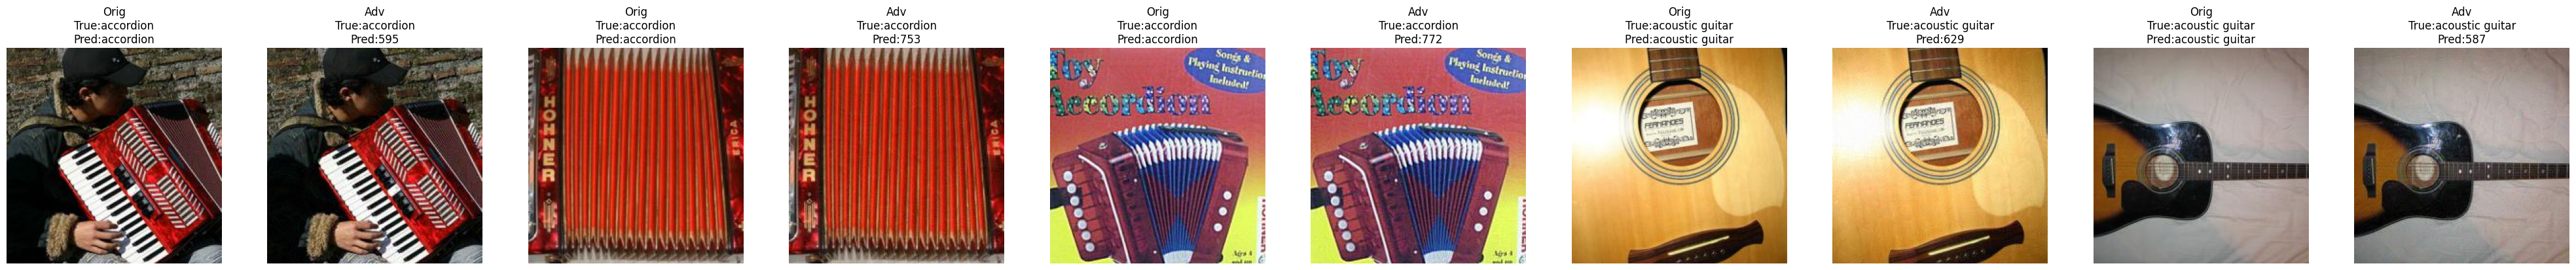

In [8]:
print("Visualizing successful examples…")
display_results(all_orig, all_adv, o_preds, a_preds, all_trues, idx2name)

### Save Adversarial Test Set 2

Loop over every image in the dataset, generate its PGD adversarial counterpart, denormalize, and save to `adversarial_test_set_2/<class>/`. Confirm that all 500 images have been saved under the correct folder structure.

In [9]:
print(f"Saving adversarial images to {ADV2_DIR}/ …")
count=0
for img, label in tqdm(dataset, total=len(dataset)):
    x = img.unsqueeze(0).to(DEVICE)
    tgt = torch.tensor([folder2idx[dataset.classes[label]]], device=DEVICE)
    adv = pgd_attack(model, x, tgt, EPSILON, ALPHA, ITERATIONS, RANDOM_START).squeeze(0).cpu()
    arr = (denormalize(adv)*255).astype(np.uint8)
    fld = dataset.classes[label]
    os.makedirs(os.path.join(ADV2_DIR,fld), exist_ok=True)
    Image.fromarray(arr).save(os.path.join(ADV2_DIR,fld, f"{count}.png"))
    count += 1

print("Adversarial Test Set 2 saved.")

Saving adversarial images to adversarial_test_set_2/ …


100%|██████████| 500/500 [01:37<00:00,  5.12it/s]

Adversarial Test Set 2 saved.
